<a href="https://colab.research.google.com/github/Kat-ies/Diploma/blob/new_latent/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 0 : libs installing & func init**

In [ ]:
# need to be installed if it's not
!pip install Ninja

In [ ]:
!python model.py install

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torchvision import transforms
import torchvision

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
def img_to_tensor(img):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(img)

def tensor_to_img(tensor):
    conv = transforms.ToPILImage()
    return conv(tensor)

def normalize_image(tensor):
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ])
    return transform(tensor)

1
NVIDIA GeForce RTX 3090


In [ ]:
import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm
from PIL import Image
import math


def generator_params(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    return (img_size, latent_len, n_mlp, chanel_miltiplier, ckpt, device)

def init_generator(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    """
    small docs : 
    img_size = 1024 # output image size of the generator
    latent = 512
    n_mlp = 8
    channel_multiplier = 2
    ckpt = 'stylegan2-ffhq-config-f.pt' # channel multiplier of the generator. config-f = 2, else = 1
    """

    g_ema = Generator(img_size, latent_len, n_mlp, channel_multiplier=chanel_miltiplier).to(device)
    checkpoint = torch.load(ckpt)
    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)

    return g_ema


# **Part 1**
Here we use StyleGAN-2 to generate image that we want to get as a result

In [ ]:
! rm -f /content/stylegan2-pytorch/sample/*

In [ ]:
#global variables

latent_len = 512
device = 'cuda'
torch.manual_seed(42)
truncation = 0.7
img_size=256

generator = init_generator(ckpt = 'C:/Users/Tony/Downloads/550000.pt', img_size=img_size)
trunc = generator.mean_latent(int(math.log(img_size, 2)) * 2 - 2)


C:\Users\Tony\AppData\Local\Temp\ipykernel_4576\1315663766.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w = torch.tensor(generator.get_latent(sample_z))


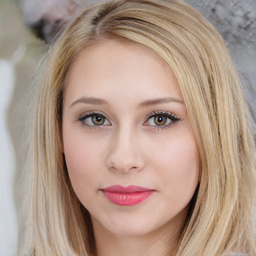

In [ ]:
torch.manual_seed(9)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device)).uniform_(-1, 1)
latent_w = torch.tensor(generator.get_latent(sample_z))

goal_image, goal_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

utils.save_image(
    goal_image,
    f"sample/goal.png",
    nrow=1,
    normalize=True,
    range=(-1, 1),
)

goal_image.to(device)

goal_img = Image.open('sample/goal.png')
goal_img

# **Part 2**
Here we will generate a new image and try to get image from part 1 impoving latent_w

C:\Users\Tony\AppData\Local\Temp\ipykernel_4576\1110187596.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w = torch.tensor(generator.get_latent(sample_z))


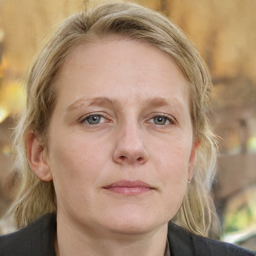

In [ ]:
torch.manual_seed(0)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device)).uniform_(-1, 1)
latent_w = torch.tensor(generator.get_latent(sample_z))

input_image, input_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

utils.save_image(
    input_image,
    f"input.png",
    nrow=1,
    normalize=True,
    range=(-1, 1),
)

input_img = Image.open('input.png')
input_img

In [ ]:
from torch import nn

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

loss_points = []
latent_w = torch.tensor(input_latent, requires_grad=True)
learning_rate = 0.1
loss_fn = nn.MSELoss()

for i in range(20000):
   # step = i % 1000 # [0, ..., 9]
    if i < 15000:
        learning_rate = 0.1
    else:
        learning_rate = 0.01
    optimizer = torch.optim.SGD([latent_w], lr=learning_rate)
    optimizer.zero_grad()
    gan_image, latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)
    
    loss = loss_fn(gan_image.to(device), goal_image)
    loss_points.append(loss.item())
    if i % 1000 == 0:
        print('loss', loss.item())
        utils.save_image(
            gan_image,
            f"sample/{str(i).zfill(6)}.png",
            nrow=1,
            normalize=True,
            range=(-1, 1),
        )
    latent_w.requires_grad_()
    loss.backward(retain_graph=True)
   # torch.nn.utils.clip_grad_norm_([latent_w], max_norm=2.0, norm_type=2)
    optimizer.step()


utils.save_image(
    gan_image,
    f"sample/final.png",
    nrow=1,\
    normalize=True,
    range=(-1, 1),
)

1
NVIDIA GeForce RTX 3090
loss 0.1735852062702179


C:\Users\Tony\AppData\Local\Temp\ipykernel_4576\3842865680.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w = torch.tensor(input_latent, requires_grad=True)
C:\Users\Tony\Downloads\stylegan2-pytorch-master\op\conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.11.0+cu113. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
c:\users\tony\appdata\local\programs\python\python39\lib\site-packages\torchvision\utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


loss 0.10854479670524597
loss 0.08759039640426636
loss 0.07591771334409714
loss 0.06965265423059464
loss 0.06540852040052414
loss 0.06293480098247528
loss 0.06057581305503845
loss 0.05830421298742294
loss 0.056728653609752655
loss 0.05458122491836548
loss 0.053412970155477524
loss 0.05257895216345787
loss 0.051577597856521606
loss 0.05116444081068039
loss 0.05000802129507065
loss 0.04952109977602959
loss 0.05019070953130722
loss 0.04991539567708969
loss 0.05001705139875412


# **Results**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loss(y_points, title = 'Loss'):
    x_points = np.arange(0, len(y_points))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score', fontsize=16, fontname='Times New Roman')
    plt.plot(x_points, y_points, color='#fb607f', linestyle='-')
    #plt.legend([''], loc='center', shadow=True, fontsize=18)
    plt.show()

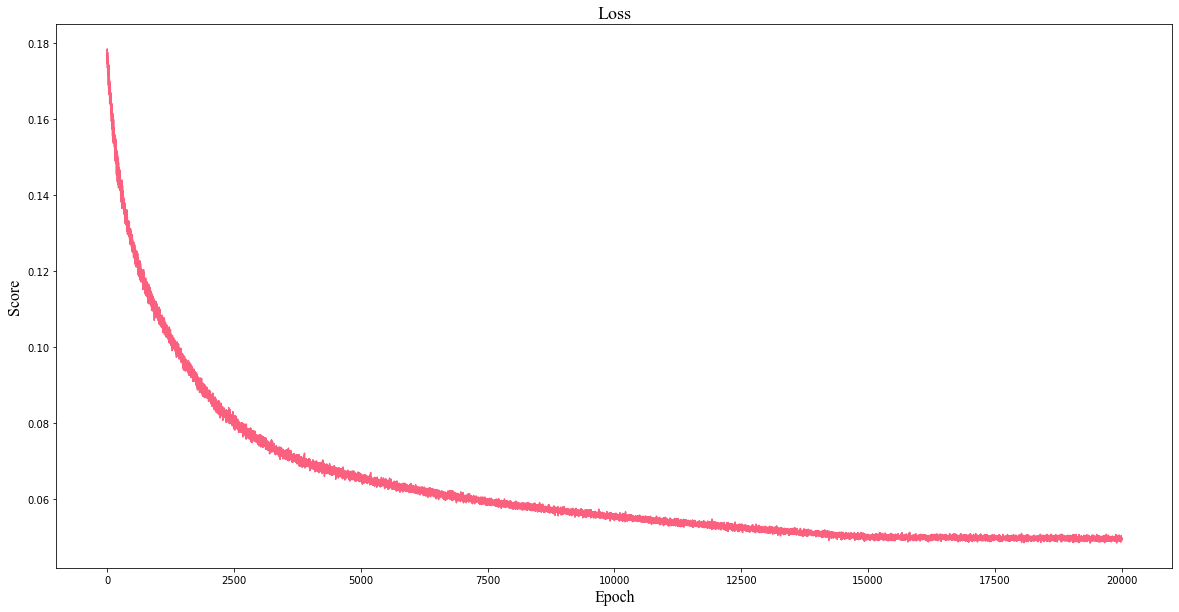

In [ ]:
plot_loss(loss_points)

In [ ]:
import os

def plot_pictures():
    images = []
    #images.append(Image.open('/content/drive/MyDrive/КУ Курсачи/Диплом/000003.png'))

    res_dir = 'sample'
    list_dirs = os.listdir(res_dir)
    list_dirs.sort()
    for cur_file in list_dirs:
        images.append(Image.open(os.path.join(res_dir, cur_file)))

    fig = plt.figure(figsize=(10, 10))
    cols = 5
    rows = 5

    ax = []

    for i in range(cols * rows):
        if i < 22:
            image = images[i]
            ax.append(fig.add_subplot(rows, cols, i + 1))
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()


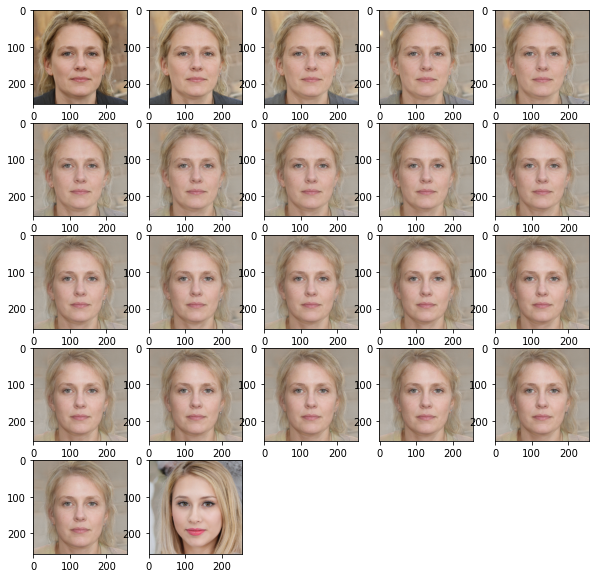

In [ ]:
plot_pictures()

In [ ]:
print('final loss:', loss_points[len(loss_points) - 1])

final loss: 0.049642033874988556
